# Connect to database

_Some initial imports and definitions:_

In [16]:
import pymongo as pm
from pymongo.errors import ConnectionFailure
from time import sleep
from ssl import CERT_NONE
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import matplotlib.pyplot as plt



def save_to_file(filename, fig=None):
    """Save to @filename with a custom set of file formats.
    
    By default, this function takes to most recent figure,
    but a @fig can also be passed to this function as an argument.
    """
    formats = [
                "pdf",
                "eps",
                "png",
                "svg",
              ]
    if fig is None:
        for form in formats:
            plt.savefig("%s.%s"%(filename, form))
    else:
        for form in formats:
            fig.savefig("%s.%s"%(filename, form))


In [17]:
# Connect to our DB

client = pm.MongoClient('10.210.9.130', ssl=True, ssl_cert_reqs=CERT_NONE,
                        username='strands', authSource='admin', authMechanism='SCRAM-SHA-1',
                        serverSelectionTimeoutMS=5000, password='Grum#Beere')
#client = pm.MongoClient('lcas.lincoln.ac.uk', port=80)
#try:
   # The ismaster command is cheap and does not require auth.
dbs = {
    'y4': client.aafy4_message_store,
    'y3': client.aafy3_message_store,
    'y2': client.aafy2_message_store
}



In [53]:

#df = pd.DataFrame(list(dbs['y4']['nav_stats'].find({})))

df = pd.DataFrame.from_records(dbs['y2']['nav_stats'].find({'status': 'failed'}))
#display(df.head())
#df[['final_node']].drop_duplicates()
#df[['operation_time']].mean()
#df.shape[0]
df.head()

,_id,_meta,date_at_node,date_finished,date_started,edge_id,final_node,mon_events,operation_time,origin,status,target,time_to_waypoint,topological_map
0,55598e21681244049ef0b2f0,"{'inserted_at': 2015-05-18 07:00:49.959000, 's...","Monday, May 18 2015, at 09:00:49 hours","Monday, May 18 2015, at 09:00:49 hours","Monday, May 18 2015, at 09:00:49 hours",WayPoint86_WayPoint90,WayPoint86,[],0.828023,WayPoint86,failed,WayPoint90,0.000000,aaf_deployment
1,555990ef681244049ef0b61c,"{'inserted_at': 2015-05-18 07:12:47.913000, 's...","Monday, May 18 2015, at 09:12:47 hours","Monday, May 18 2015, at 09:12:47 hours","Monday, May 18 2015, at 09:12:47 hours",WayPoint26_WayPoint90,WayPoint26,[],0.619103,WayPoint26,failed,WayPoint90,0.000000,aaf_deployment
2,55599183681244049ef0b8d8,"{'inserted_at': 2015-05-18 07:15:15.435000, 's...","Monday, May 18 2015, at 09:15:13 hours","Monday, May 18 2015, at 09:15:15 hours","Monday, May 18 2015, at 09:14:58 hours",WayPoint88_Kindergarten,Kindergarten,[],17.021091,WayPoint88,failed,Kindergarten,2.381081,aaf_deployment
3,55599c69681244049ef10cfd,"{'inserted_at': 2015-05-18 08:01:45.338000, 's...","Monday, May 18 2015, at 10:01:44 hours","Monday, May 18 2015, at 10:01:45 hours","Monday, May 18 2015, at 10:01:44 hours",WayPoint86_WayPoint90,WayPoint86,[],0.828731,WayPoint86,failed,WayPoint90,0.000000,aaf_deployment
4,55599e96681244049ef11538,"{'inserted_at': 2015-05-18 08:11:02.321000, 's...","Monday, May 18 2015, at 10:11:01 hours","Monday, May 18 2015, at 10:11:02 hours","Monday, May 18 2015, at 10:11:01 hours",WayPoint26_WayPoint90,WayPoint26,[],0.759469,WayPoint26,failed,WayPoint90,0.000000,aaf_deployment


In [80]:
# monitored nav events
coll = dbs['y4']['monitored_nav_events']
#print(coll.count())
pipeline = [
    {
        '$limit': 5000
    },
    {
        '$project': {
            'start_pose_x': '$event_start_pose.position.x',
            'start_pose_y': '$event_start_pose.position.y',
            'end_pose_x': '$event_end_pose.position.x',
            'end_pose_y': '$event_end_pose.position.y',
            'start_time': {'$add': ['$event_start_time.secs', {'$divide': ['$event_start_time.nsecs', 1000000000.0]}]},
            'start_time_secs': '$event_start_time.secs',
            'start_time_nsecs': '$event_start_time.nsecs',
            'end_time': {'$add': ['$event_end_time.secs', {'$divide': ['$event_end_time.nsecs', 1000000000.0]}]},
            'end_time_secs': '$event_end_time.secs',
            'end_time_nsecs': '$event_end_time.nsecs',
            'was_helped': 1, 'n_help_requests': 1,
            'edge_id': 1,
            'recover_mechanism': 1,
            'inserted_at': '$_meta.inserted_at'
        }
    }
]

agg = coll.aggregate(pipeline)

df = pd.DataFrame.from_records(agg)
df.to_pickle('MNE_y4.p')
df.head()


,_id,edge_id,end_pose_x,end_pose_y,end_time,end_time_nsecs,end_time_secs,inserted_at,n_help_requests,recover_mechanism,start_pose_x,start_pose_y,start_time,start_time_nsecs,start_time_secs,was_helped
0,5821c167b63c4d097bada237,,-18.140426,-70.186561,1.478607e+09,504234075,1478607207,2016-11-08 12:13:27.740,1,sleep_and_retry,-18.140426,-70.186561,1.478607e+09,137943983,1478607201,False
1,5821c17cb63c4d097bada239,,-18.140426,-70.186561,1.478607e+09,617881059,1478607228,2016-11-08 12:13:48.669,2,backtrack,-18.140426,-70.186561,1.478607e+09,448864936,1478607225,False
2,5821c19cb63c4d097bada23b,,-18.026326,-69.862764,1.478607e+09,672528982,1478607260,2016-11-08 12:14:20.933,1,sleep_and_retry,-18.026326,-69.862764,1.478607e+09,452892065,1478607254,False
3,5821c1c5b63c4d097bada23d,,-18.594153,-70.210300,1.478607e+09,328999042,1478607301,2016-11-08 12:15:01.503,2,backtrack,-18.026326,-69.862764,1.478607e+09,197510004,1478607278,False
4,5821c1dcb63c4d097bada23f,,-18.592843,-70.209768,1.478607e+09,986634016,1478607323,2016-11-08 12:15:24.080,3,backtrack,-18.594153,-70.210300,1.478607e+09,714020967,1478607319,False


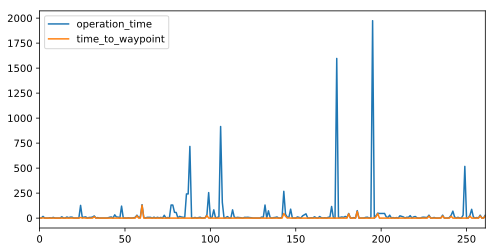

In [20]:

matplotlib.rcParams['figure.figsize'] = (8, 4)

df.plot()
save_to_file('initial')